<center><img src="https://zillow.mediaroom.com/download/Zillow_Wordmark_Blue_RGB+lrg.png" width=400 /></center>

# Project Goals

To create a predictive model for Single Family Residential houses that performs better than the baseline.

# Project Description

This project uses the Zillow dataset from 2017 for the LA, Orange, and Ventura counties. The predictive modeling is based on the number of bedrooms and bathrooms, square footage, year built, and ground area to provide an estimate for a given property's value (in 2017 dollars).

# Initial Hypothesis

Bedrooms, bathrooms, and square footage are the best predictors for house prices.

# Workflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import wrangle as w
import explore as ex
import evaluate as ev

In [2]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Wrangling Data

- Imported from CodeUp server.
- Retrieved bedrooms, bathrooms, square footage, year built, ground area (lot size minus sqft), and property value.
- Removed null values.
- Handled outliers:
    - Reduced beds and baths to range 1 through 7.
    - Square footage to range 120 to 5,000.
    - Removed houses built before 1875.
    - Limited ground area to 320 - 15,000 sqft.
    - Cut of bottom and top 1% of property values.
- Split into train, validate, and test.

In [4]:
train, validate, test = w.wrangle_zillow()

In [5]:
train.head()

,bedrooms,bathrooms,sqft,prop_value,yearbuilt,county,ground_area
10366,4,2.0,1850,379685,1954,Orange,4150.0
45899,3,2.0,1464,77361,1969,Orange,4775.0
27596,5,3.0,2600,996864,1996,Orange,3016.0
31229,3,2.0,1165,351598,1953,LA,6310.0
6776,3,1.0,1208,218668,1951,LA,3792.0


## Explore

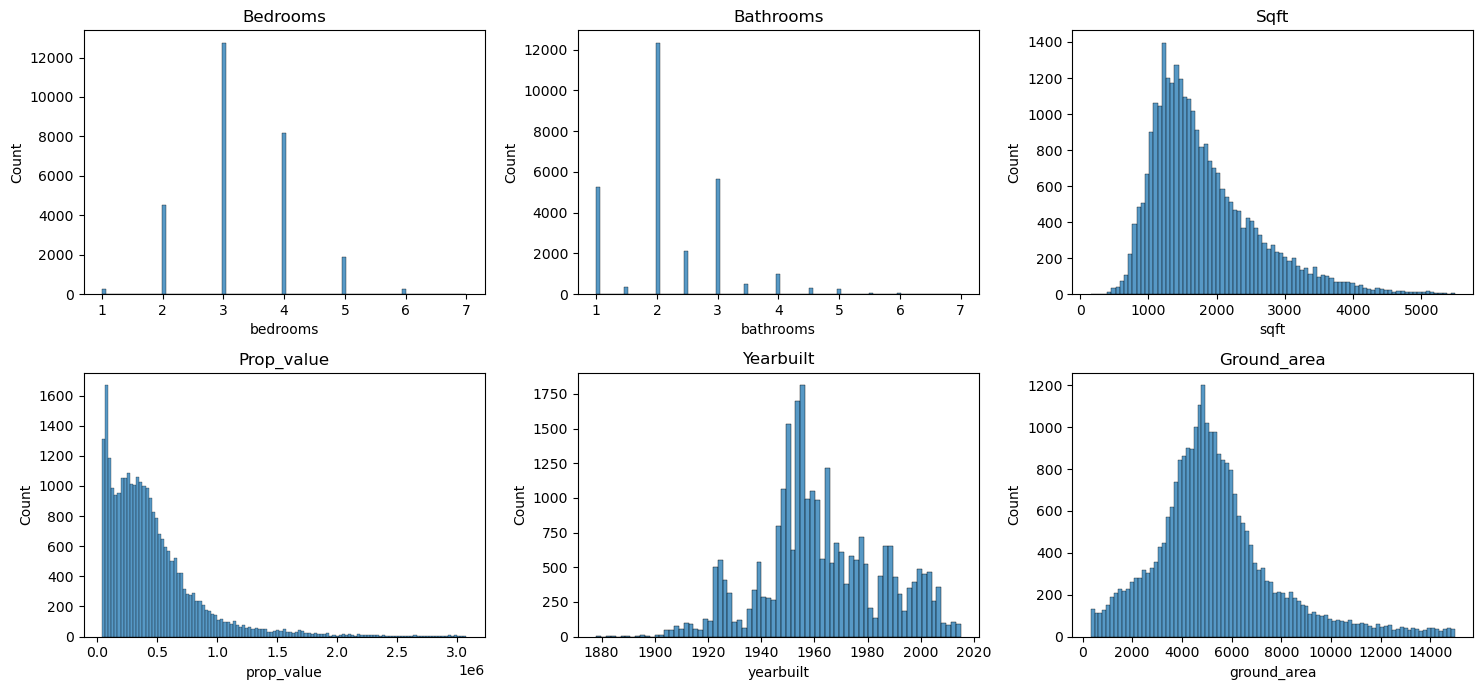

In [6]:
#Visualizing histograms for individual variables

plt.figure(figsize=(15, 7))

for i, col in enumerate(train.drop(columns='county')):
    plt.subplot(2, 3, i+1)
    plt.title(col.capitalize())
    sns.histplot(train[col])
plt.tight_layout()   
plt.show()

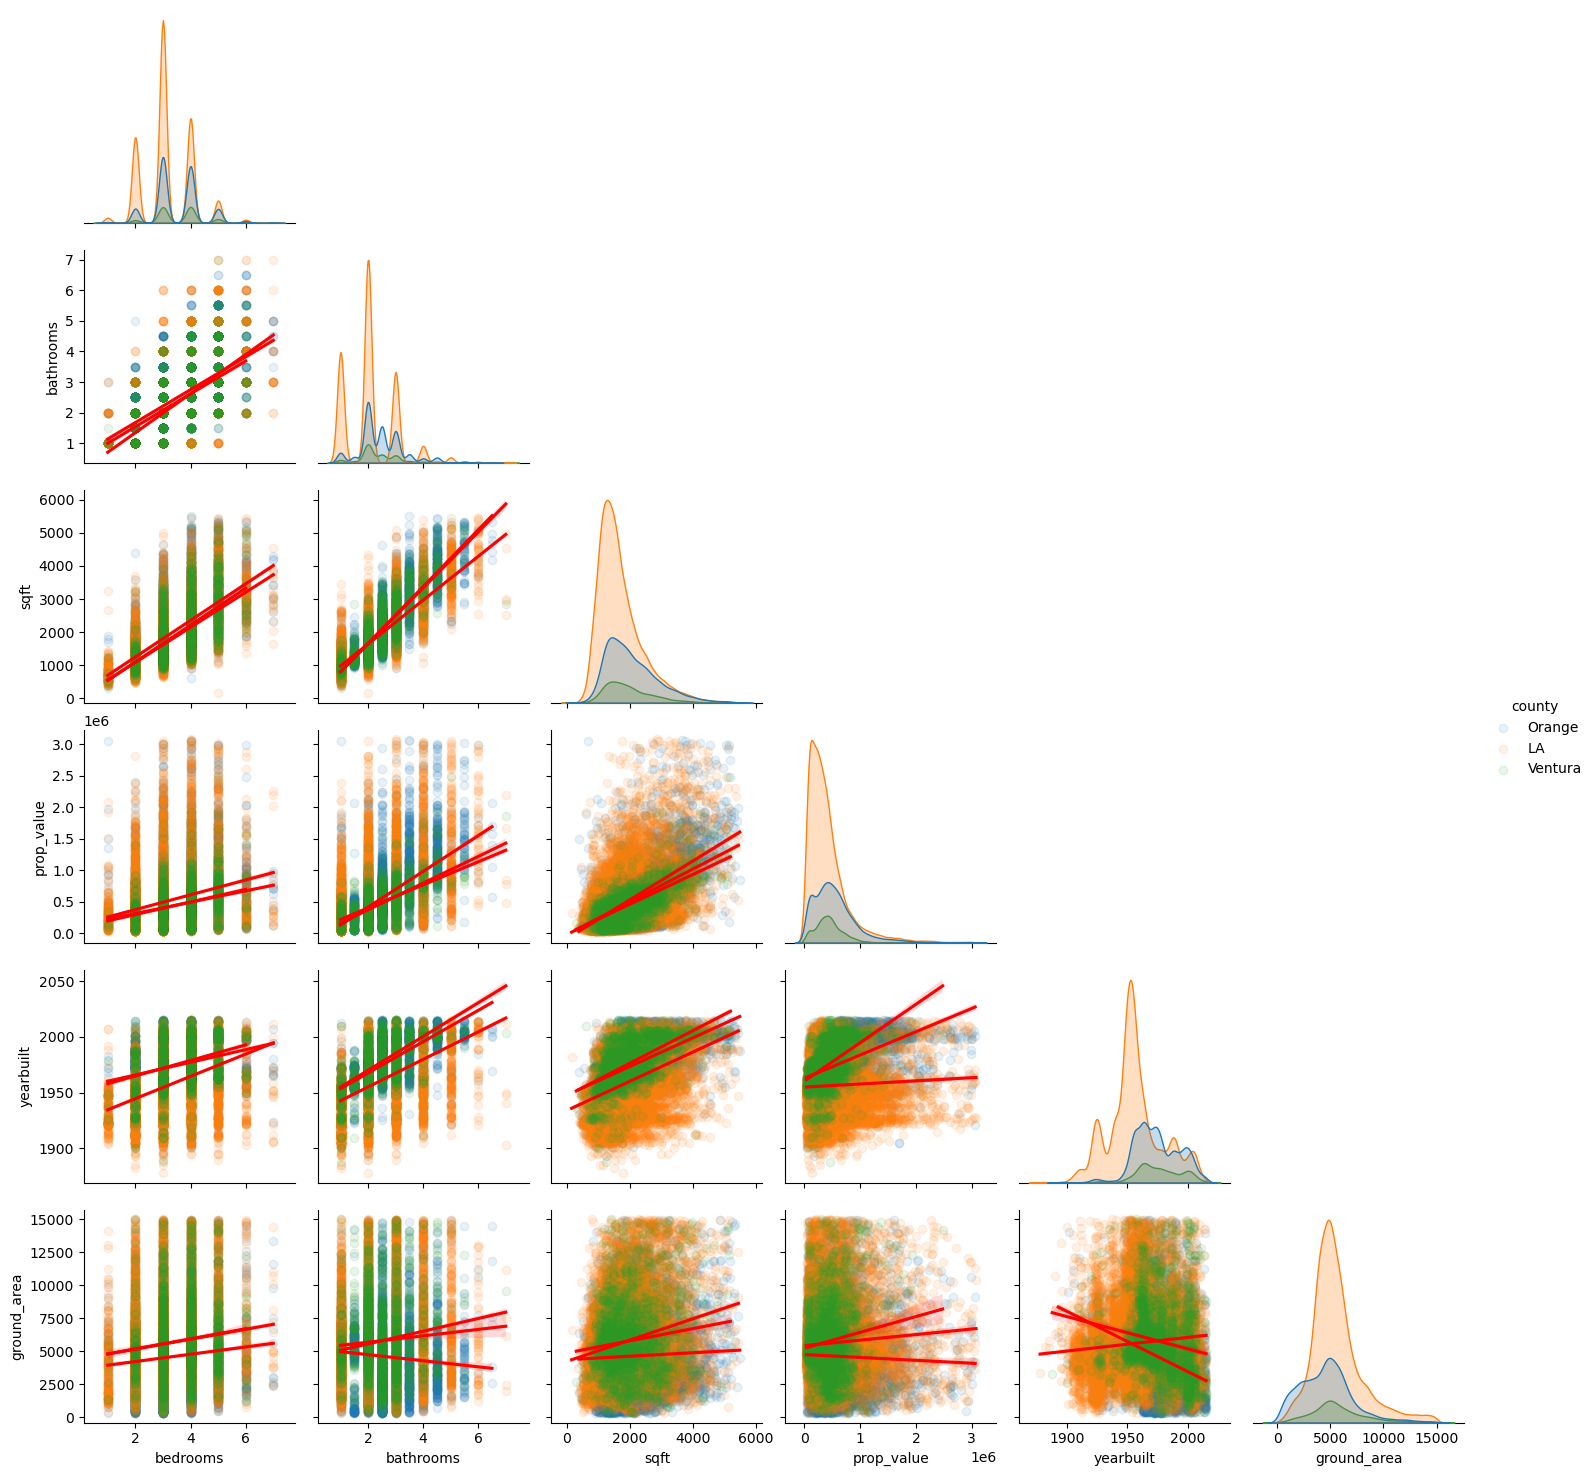

In [7]:
ex.plot_variable_pairs(train, 'county')

## Hypotheses and Stats Testing

### Is there a relationship between numeric variables and property value?

$H_0$: There is no correlation between numeric variables and property value.

$H_\alpha$: There is a correlation between numeric variables and property value.

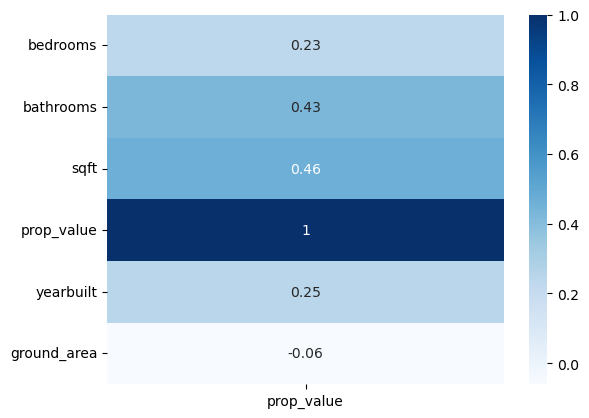

In [8]:
matrix = train.corr(method='spearman')
sns.heatmap(pd.DataFrame(matrix.prop_value), annot=True, cmap="Blues"
      #      , mask=train.prop_value
           )
plt.show()

Even though the correlation coefficient is low, because the p-value is 0 across all variables, we can reject the null hypothesis.

### Is there multicollinearity between bedrooms and bathrooms?

$H_0$: There is no correlation between bedrooms and bathrooms.

$H_\alpha$: There is a correlation between bedrooms and bathrooms.

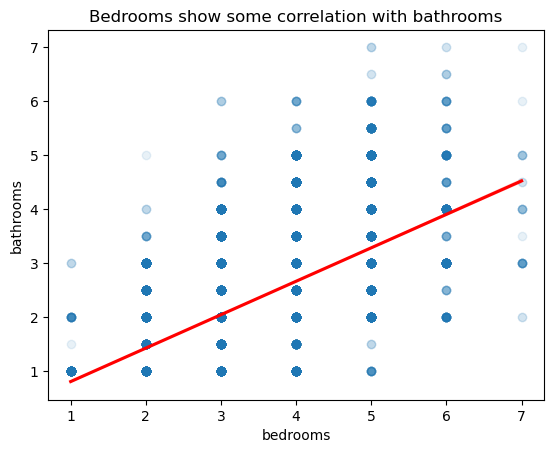

In [9]:
sns.regplot(data=train, x='bedrooms', y='bathrooms', line_kws={'color':'red'}, scatter_kws={'alpha': 0.1})
plt.title('Bedrooms show some correlation with bathrooms')
plt.show()

In [10]:
r, p = stats.spearmanr(train.bedrooms, train.bathrooms)

print(f'The correlation coefficient between bedrooms and bathrooms is: {round(r, 2)}')
print(f'The p-value is: {p}')

The correlation coefficient between bedrooms and bathrooms is: 0.62
The p-value is: 0.0


Although we can see that there is a good correlation between the two, it is not so strong that we would suspect high dependency between the two variables.

### Are the mean value prices significantly different across counties?

$H_0$: There is no statistically significant difference in the mean property value across counties.

$H_\alpha$: There is a statistically significant difference in the mean property value across counties.

In [26]:
print('Means of Property Values')
print(f'LA: {round(train_scaled[train_scaled.county == "LA"].prop_value.mean(), 2)}')
print(f'Ventura: {round(train_scaled[train_scaled.county == "Ventura"].prop_value.mean(), 2)}')
print(f'Orange: {round(train_scaled[train_scaled.county == "Orange"].prop_value.mean(), 2)}')

Means of Property Values
LA: 415129.27
Ventura: 450225.37
Orange: 547813.49


# Modeling

## Scaling

Adjust values of numeric features so they are all equally weighted when modeling.

In [12]:
cols = ['bedrooms', 'bathrooms', 'sqft', 'yearbuilt', 'ground_area']

train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test, cols)

In [13]:
#Pulse check
train_scaled.head()

,bedrooms,bathrooms,sqft,prop_value,yearbuilt,county,ground_area
10366,1.0,0.0,0.242489,379685,-0.214286,Orange,-0.355182
45899,0.0,0.0,-0.171674,77361,0.321429,Orange,-0.099140
27596,2.0,1.0,1.047210,996864,1.285714,Orange,-0.819746
31229,0.0,0.0,-0.492489,351598,-0.250000,LA,0.529701
6776,0.0,-1.0,-0.446352,218668,-0.321429,LA,-0.501844


## Feature Selection

Run dataset through model to select the three most influential features.

In [14]:
rfe = RFE(LinearRegression(normalize=True), n_features_to_select=3)
rfe.fit(train_scaled[cols], train_scaled.prop_value)
train_scaled[cols].iloc[:, rfe.support_].columns.tolist()

['bedrooms', 'bathrooms', 'sqft']

## Establishing a baseline

Establish a baseline and check the RMSE score to beat.

In [15]:
#Establish baseline

baseline = train_scaled.prop_value.mean()

ev.baseline_mean_errors(train_scaled.prop_value)

RMSE for baseline = 392154.5751996843


## Run data through models

Input the data into several models and compare scores so as to select our best model.
   - MLR: Multiple Linear Regression
   - LASSO: Least Absolute Shrinkage and Selection Operator - Least Angle Regression
   - GLM: Generalize Linear Model
   - Poly: Polynomial Regression

In [16]:
ev.create_models(train_scaled, 
                 validate_scaled, 
                 ['bedrooms', 'bathrooms', 'sqft'], 
                 train_scaled.prop_value, 
                 validate_scaled.prop_value)

,model,rmse_train,rmse_validate,r2_train,r2_validate
0,baseline,392154.575200,392154.575200,0.000000,0.000000
1,MLR,322529.927396,320102.308981,0.323566,0.347643
2,LASSO,322530.981436,320115.607762,0.323562,0.347589
3,GLM,321840.836492,317980.678156,0.326453,0.356262
4,Poly,317558.156706,315978.957480,0.344260,0.364341


Send in all numeric features to test model performance.

In [17]:
ev.create_models(train_scaled, 
                 validate_scaled, 
                 ['bedrooms', 'bathrooms', 'sqft', 'yearbuilt', 'ground_area'], 
                 train_scaled.prop_value, 
                 validate_scaled.prop_value)

,model,rmse_train,rmse_validate,r2_train,r2_validate
0,baseline,392154.575200,392154.575200,0.000000,0.000000
1,MLR,319904.842775,316825.940796,0.334532,0.360929
2,LASSO,319906.788462,316849.310136,0.334524,0.360835
3,GLM,320709.617237,316816.578890,0.331180,0.360967
4,Poly,309540.001180,311385.787482,0.376956,0.382687


## Run model on Test

In [18]:
ev.test_model(train_scaled, 
              test_scaled,
              ['bedrooms', 'bathrooms', 'sqft', 'yearbuilt', 'ground_area'], 
              train_scaled.prop_value,
              test_scaled.prop_value)

,model,rmse_test,r2_test
0,Poly,319864.337054,0.351484


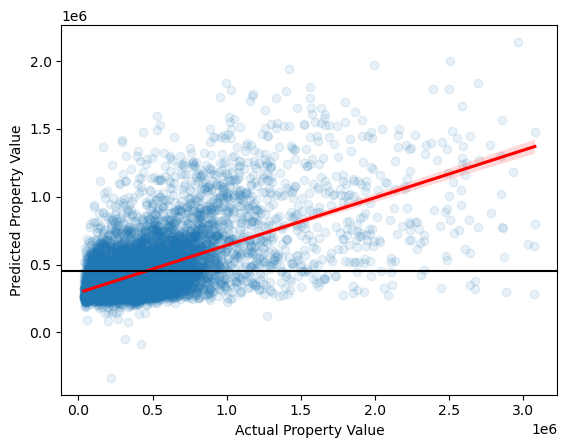

In [20]:
ev.get_act_pred_viz(train_scaled, 
              test_scaled,
              ['bedrooms', 'bathrooms', 'sqft', 'yearbuilt', 'ground_area'], 
              train_scaled.prop_value,
              test_scaled.prop_value)

## Key Findings

- International Residential Code: 120 sqft minimum for houses, 320 sqft for lots.
- Ground area was the worst predictor of property value, but still aided in modeling.
- Polynomial regression with degree=4 consistently outperformed all other models.

# Recommendations and Next Steps

- Best predictor may be neighborhoods, preferably those set by the real estate market.